In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))

import warnings
import pandas as pd
import pickle

from tqdm import tqdm
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from pathlib import Path
base_path = os.path.join(os.path.dirname(os.getcwd()))
print(f"Base path: {base_path}")
data_path = Path(base_path, "data", "bepro", "processed")
yaml_file = Path(base_path, "assertion", "transitions.yaml")

from assertion.bepro import convert_to_actions
from assertion.validator import Validator

Base path: /root/express-v2


In [2]:
match_id_lst = os.listdir(data_path)
print(match_id_lst)
match_id = match_id_lst[0]  # Change this to the desired match ID
match_id

['126424', '126364', '126332', '153387', '126386', '126306', '126380', '126401', '126356', '126433', '126458', '126476', '126309']


'126424'

In [3]:
with open(f"{data_path}/{match_id}/{match_id}_processed_dict.pkl", "rb") as f:
    match_dict = pickle.load(f)
    
    events = match_dict['event_df']
    teams_dict = match_dict['teams']
    metadata = match_dict['meta_data']
    tracking_df = match_dict['tracking_df']

pd.concat([events.groupby("period_order").head(1), 
           events.groupby("period_order").tail(1)])

,period_type,period_name,period_order,period_duration,period_start_time,event_time,team_name,player_shirt_number,player_name,events,x,y,to_x,to_y,attack_direction
0,Half,1st Half,0,2700000,0,533,Gwangju FC,99,Beka Mikeltadze,"[{'event_name': 'Passes', 'property': {'Outcom...",0.4976,0.5045,0.4236,0.6365,RIGHT
0,Half,2nd Half,1,2700000,2700000,2700300,Daegu FC,17,Italo Carvalho,"[{'event_name': 'Passes', 'property': {'Outcom...",0.4977,0.5119,0.4088,0.5073,RIGHT
1600,Half,1st Half,0,2700000,0,2879667,Gwangju FC,11,Gabriel,"[{'event_name': 'Fouls', 'property': {'Type': ...",0.5844,0.0887,NaN,NaN,RIGHT
1836,Half,2nd Half,1,2700000,2700000,6004233,Gwangju FC,22,Sanggi Lee,"[{'event_name': 'Duels', 'property': {'Type': ...",0.9684,0.6135,NaN,NaN,LEFT


In [4]:
teams_df = pd.concat([teams_dict["Home"], teams_dict["Away"]], ignore_index=True)
player_name_to_player_id = {row.player: int(row.pID) for row in teams_df.itertuples()}
player_id_to_team_id = {int(row.pID): int(row.tID) for row in teams_df.itertuples()}
player_id_to_team = {int(row.pID): row.team for row in teams_df.itertuples()}

events["game_id"] = match_id
events["event_id"] = range(len(events))
events["player_id"] = events["player_name"].map(player_name_to_player_id).astype(int)
events["team_id"] = events["player_id"].map(player_id_to_team_id).astype(int)
events["team"] = events["player_id"].map(player_id_to_team)
events

,period_type,period_name,period_order,period_duration,period_start_time,event_time,team_name,player_shirt_number,player_name,events,x,y,to_x,to_y,attack_direction,game_id,event_id,player_id,team_id,team
0,Half,1st Half,0,2700000,0,533,Gwangju FC,99,Beka Mikeltadze,"[{'event_name': 'Passes', 'property': {'Outcom...",0.4976,0.5045,0.4236,0.6365,RIGHT,126424,0,408383,4648,Away
1,Half,1st Half,0,2700000,0,1667,Gwangju FC,10,Huigyun Lee,"[{'event_name': 'Passes Received', 'property':...",0.4236,0.6365,NaN,NaN,RIGHT,126424,1,77414,4648,Away
2,Half,1st Half,0,2700000,0,5167,Gwangju FC,10,Huigyun Lee,"[{'event_name': 'Passes', 'property': {'Outcom...",0.4464,0.6543,0.3413,0.7579,RIGHT,126424,2,77414,4648,Away
3,Half,1st Half,0,2700000,0,6500,Gwangju FC,18,Yool Heo,"[{'event_name': 'Passes Received', 'property':...",0.3413,0.7579,NaN,NaN,RIGHT,126424,3,145703,4648,Away
4,Half,1st Half,0,2700000,0,15021,Gwangju FC,18,Yool Heo,"[{'name': 'VHIR', 'property': {'duration': 500...",0.3500,0.5752,0.3501,0.5339,RIGHT,126424,4,145703,4648,Away
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1832,Half,2nd Half,1,2700000,2700000,5999333,Daegu FC,11,Cesinha,"[{'event_name': 'Passes Received', 'property':...",0.8861,0.1069,NaN,NaN,RIGHT,126424,3433,62112,4644,Home
1833,Half,2nd Half,1,2700000,2700000,6000600,Daegu FC,11,Cesinha,"[{'event_name': 'Passes', 'property': {'Outcom...",0.8691,0.1376,0.7890,0.2495,RIGHT,126424,3434,62112,4644,Home
1834,Half,2nd Half,1,2700000,2700000,6002367,Daegu FC,2,Jaewon Hwang,"[{'event_name': 'Crosses', 'property': {'Outco...",0.7890,0.2495,0.9670,0.6118,RIGHT,126424,3435,250055,4644,Home
1835,Half,2nd Half,1,2700000,2700000,6004200,Daegu FC,17,Italo Carvalho,"[{'event_name': 'Duels', 'property': {'Type': ...",0.9670,0.6118,NaN,NaN,RIGHT,126424,3436,530662,4644,Home


In [5]:
actions = convert_to_actions(events)
actions

,game_id,original_event_id,action_id,period_id,time_seconds,relative_time_seconds,team_id,player_id,relative_player_id,reactor_team_id,...,type_id,result_name,relative_id,pair_id,start_x,start_y,end_x,end_y,dx,dy
0,126424.0,0,0.0,1.0,0.533,1.667,4648.0,408383.0,77414.0,-1.0,...,38.0,Successful,1.0,-1.0,52.7520,33.6940,60.5220,24.7180,7.7700,-8.9760
1,126424.0,1,1.0,1.0,1.667,NaN,4648.0,77414.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,60.5220,24.7180,60.5220,24.7180,0.0000,0.0000
2,126424.0,2,2.0,1.0,5.167,6.500,4648.0,77414.0,145703.0,-1.0,...,38.0,Successful,3.0,-1.0,58.1280,23.5076,69.1635,16.4628,11.0355,-7.0448
3,126424.0,3,3.0,1.0,6.500,NaN,4648.0,145703.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,69.1635,16.4628,69.1635,16.4628,0.0000,0.0000
4,126424.0,5,4.0,1.0,15.933,17.733,4648.0,145703.0,250100.0,-1.0,...,38.0,Successful,6.0,-1.0,68.5650,33.9524,70.5495,61.4992,1.9845,27.5468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,126424.0,3435,2299.0,2.0,3302.367,NaN,4644.0,250055.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,82.8450,16.9660,101.5350,41.6024,18.6900,24.6364
2300,126424.0,3435,2300.0,2.0,3302.367,NaN,4644.0,250055.0,-1.0,-1.0,...,39.0,Unsuccessful,-1.0,-1.0,82.8450,16.9660,101.5350,41.6024,18.6900,24.6364
2301,126424.0,3436,2301.0,2.0,3304.200,NaN,4644.0,530662.0,-1.0,-1.0,...,17.0,Unsuccessful,-1.0,3437.0,101.5350,41.6024,101.5350,41.6024,0.0000,0.0000
2302,126424.0,3437,2302.0,2.0,3304.233,NaN,4648.0,250100.0,-1.0,-1.0,...,17.0,Successful,-1.0,3436.0,101.6820,41.7180,101.6820,41.7180,0.0000,0.0000


In [6]:
validator = Validator(actions, yaml_file)
validator.validate_sequence()
valid_events = validator.df_events
valid_events

,game_id,original_event_id,action_id,period_id,time_seconds,relative_time_seconds,team_id,player_id,relative_player_id,reactor_team_id,...,type_id,result_name,relative_id,pair_id,start_x,start_y,end_x,end_y,dx,dy
0,126424.0,0,0,1.0,0.533,1.667,4648.0,408383.0,77414.0,-1.0,...,38.0,Successful,1.0,-1.0,52.7520,33.6940,60.5220,24.7180,7.7700,-8.9760
1,126424.0,1,1,1.0,1.667,NaN,4648.0,77414.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,60.5220,24.7180,60.5220,24.7180,0.0000,0.0000
2,126424.0,2,2,1.0,5.167,6.500,4648.0,77414.0,145703.0,-1.0,...,38.0,Successful,3.0,-1.0,58.1280,23.5076,69.1635,16.4628,11.0355,-7.0448
3,126424.0,3,3,1.0,6.500,NaN,4648.0,145703.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,69.1635,16.4628,69.1635,16.4628,0.0000,0.0000
4,126424.0,NaN,4,1.0,6.501,NaN,4648.0,145703.0,NaN,-1.0,...,28.0,NaN,NaN,NaN,69.1635,16.4628,68.5650,33.9524,-0.5985,17.4896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2831,126424.0,3435,2831,2.0,3302.367,NaN,4644.0,250055.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,82.8450,16.9660,101.5350,41.6024,18.6900,24.6364
2832,126424.0,3435,2832,2.0,3302.367,NaN,4644.0,250055.0,-1.0,-1.0,...,39.0,Unsuccessful,-1.0,-1.0,82.8450,16.9660,101.5350,41.6024,18.6900,24.6364
2833,126424.0,3437,2833,2.0,3304.233,NaN,4648.0,250100.0,NaN,4644.0,...,17.0,Successful,NaN,NaN,101.6820,41.7180,101.6820,41.7180,0.0000,0.0000
2834,126424.0,NaN,2834,2.0,3304.233,NaN,4648.0,250100.0,NaN,-1.0,...,20.0,NaN,NaN,NaN,101.6820,41.7180,101.6820,41.7180,0.0000,0.0000


In [7]:
validator.df_errors

,game_id,event_id,current_state,next_state,event,error
0,126424.0,3.0,in_possession,in_possession,Carry,Dribble Add
1,126424.0,9.0,in_possession,in_possession,Carry,Dribble Add
2,126424.0,11.0,in_possession,in_possession,Carry,Dribble Add
3,126424.0,23.0,in_possession,in_possession,Carry,Dribble Add
4,126424.0,30.0,in_possession,in_possession,Carry,Dribble Add
...,...,...,...,...,...,...
593,126424.0,3395.0,in_possession,in_possession,Carry,Dribble Add
594,126424.0,3405.0,in_possession,in_possession,Carry,Dribble Add
595,126424.0,3415.0,in_possession,in_possession,Carry,Dribble Add
596,126424.0,NaN,ball_neutral,set_piece,Out,Resolved


In [8]:
import assertion.config as lsdpconfig

PITCH_X_MIN, PITCH_X_MAX = -52.5, 52.5
PITCH_Y_MIN, PITCH_Y_MAX = -34.0, 34.0

valid_events_filtered = valid_events.copy()

for col in ["start_x", "end_x"]:
    valid_events_filtered[col] += PITCH_X_MIN
for col in ["start_y", "end_y"]:
    valid_events_filtered[col] += PITCH_Y_MIN

valid_events_filtered["type_name"] = valid_events_filtered["type_name"].map(lsdpconfig.versa_to_spadl_dict)
valid_events_filtered = valid_events_filtered[valid_events_filtered["type_name"] != "non_action"].reset_index(drop=True)
valid_events_filtered["type_id"] = valid_events_filtered["type_name"].apply(lambda t: lsdpconfig.spadl_actiontypes.index(t))
valid_events_filtered

,game_id,original_event_id,action_id,period_id,time_seconds,relative_time_seconds,team_id,player_id,relative_player_id,reactor_team_id,...,type_id,result_name,relative_id,pair_id,start_x,start_y,end_x,end_y,dx,dy
0,126424.0,0,0,1.0,0.533,1.667,4648.0,408383.0,77414.0,-1.0,...,7,Successful,1.0,-1.0,0.2520,-0.3060,8.0220,-9.2820,7.7700,-8.9760
1,126424.0,2,2,1.0,5.167,6.500,4648.0,77414.0,145703.0,-1.0,...,7,Successful,3.0,-1.0,5.6280,-10.4924,16.6635,-17.5372,11.0355,-7.0448
2,126424.0,NaN,4,1.0,6.501,NaN,4648.0,145703.0,NaN,-1.0,...,16,NaN,NaN,NaN,16.6635,-17.5372,16.0650,-0.0476,-0.5985,17.4896
3,126424.0,5,5,1.0,15.933,17.733,4648.0,145703.0,250100.0,-1.0,...,7,Successful,6.0,-1.0,16.0650,-0.0476,18.0495,27.4992,1.9845,27.5468
4,126424.0,7,7,1.0,21.433,22.700,4648.0,250100.0,250101.0,-1.0,...,7,Successful,8.0,-1.0,16.7475,26.4860,14.9835,10.9208,-1.7640,-15.5652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760,126424.0,3432,2828,2.0,3298.000,3299.333,4644.0,62119.0,62112.0,-1.0,...,17,Successful,3433.0,-1.0,52.5000,-32.9596,40.5405,-26.7308,-11.9595,6.2288
1761,126424.0,3434,2830,2.0,3300.600,3302.367,4644.0,62112.0,250055.0,-1.0,...,7,Successful,3435.0,-1.0,38.7555,-24.6432,30.3450,-17.0340,-8.4105,7.6092
1762,126424.0,3435,2832,2.0,3302.367,NaN,4644.0,250055.0,-1.0,-1.0,...,12,Unsuccessful,-1.0,-1.0,30.3450,-17.0340,49.0350,7.6024,18.6900,24.6364
1763,126424.0,NaN,2834,2.0,3304.233,NaN,4648.0,250100.0,NaN,-1.0,...,2,NaN,NaN,NaN,49.1820,7.7180,49.1820,7.7180,0.0000,0.0000


In [9]:
import numpy as np
fps = 25

tracking_df["time"] = np.where(
    tracking_df["period_id"] == 1,
    tracking_df["frame_id"] / fps,
    tracking_df["frame_id"] / fps - 45*60
)

pd.concat([tracking_df.groupby("period_id").head(1), tracking_df.groupby("period_id").tail(1)]).sort_values("period_id")

,game_id,period_id,timestamp,frame_id,ball_state,ori_ball_owning_team_id,x,y,z,vx,...,ax,ay,az,a,id,team_id,position_name,ball_owning_team_id,is_ball_carrier,time
0,126424,1.0,0 days 00:00:00.621000,15,alive,4648,-18.8076,12.7844,0.0,-0.176709,...,0.305389,-0.311730,0.0,0.436392,145703,4648,CB,4648,False,0.6
1653377,126424,1.0,0 days 00:47:59.621000,71990,dead,4648,8.3447,-27.6795,0.0,15.446591,...,-2.001592,1.113759,0.0,2.290596,ball,ball,ball,4648,False,2879.6
1653378,126424,2.0,0 days 00:45:00.005000,67500,alive,4648,15.0015,-9.2811,0.0,0.012436,...,0.000000,0.000000,0.0,0.000000,145703,4648,CB,4648,False,0.0
3546645,126424,2.0,0 days 01:40:04.205000,150105,alive,4644,49.1867,7.7176,0.0,13.531888,...,50.344207,37.765964,0.0,13.500000,ball,ball,ball,4644,False,3304.2


In [10]:
team_sheets = pd.concat([teams_dict["Home"], teams_dict["Away"]], ignore_index=True)
team_sheets["pID"] = team_sheets["pID"].astype(int)
team_sheets["tID"] = team_sheets["tID"].astype(int)
team_sheets

,player,position,team,jID,pID,tID,xID
0,Youngeun Choi,None,Home,1,62082,4644,0
1,Jaehyeon Go,None,Home,10,62098,4644,1
2,Italo Carvalho,CF,Home,17,530662,4644,2
3,Jaewon Hwang,RWB,Home,2,250055,4644,3
4,Seunghoon Oh,GK,Home,21,250060,4644,4
5,Chiin Jeong,RW,Home,32,62119,4644,5
6,Sung Won Jang,None,Home,22,62105,4644,6
7,Jinhyuk Kim,CB,Home,7,62086,4644,7
8,Lucas Barcelos,LW,Home,99,342722,4644,8
9,Jinyoung Park,CB,Home,40,500515,4644,9


In [20]:
pd.concat([valid_events_filtered.groupby("period_id").head(1), 
           valid_events_filtered.groupby("period_id").tail(1)]).sort_values("period_id")

,game_id,original_event_id,action_id,period_id,time_seconds,relative_time_seconds,team_id,player_id,relative_player_id,reactor_team_id,...,type_id,result_name,relative_id,pair_id,start_x,start_y,end_x,end_y,dx,dy
0,126424.0,0,0,1.0,0.533,1.667,4648.0,408383.0,77414.0,-1.0,...,7,Successful,1.0,-1.0,0.2520,-0.3060,8.022,-9.2820,7.7700,-8.9760
797,126424.0,1599,1306,1.0,2879.600,NaN,4644.0,250076.0,NaN,4648.0,...,13,NaN,NaN,NaN,-9.1350,28.1656,-9.135,28.1656,0.0000,0.0000
798,126424.0,1601,1307,2.0,0.300,1.367,4644.0,530662.0,500505.0,-1.0,...,7,Successful,1602.0,-1.0,-0.2415,0.8092,-9.576,0.4964,-9.3345,-0.3128
1764,126424.0,3437,2835,2.0,3304.233,NaN,4648.0,250100.0,-1.0,-1.0,...,1,NaN,-1.0,3436.0,49.1820,7.7180,49.182,7.7180,0.0000,0.0000


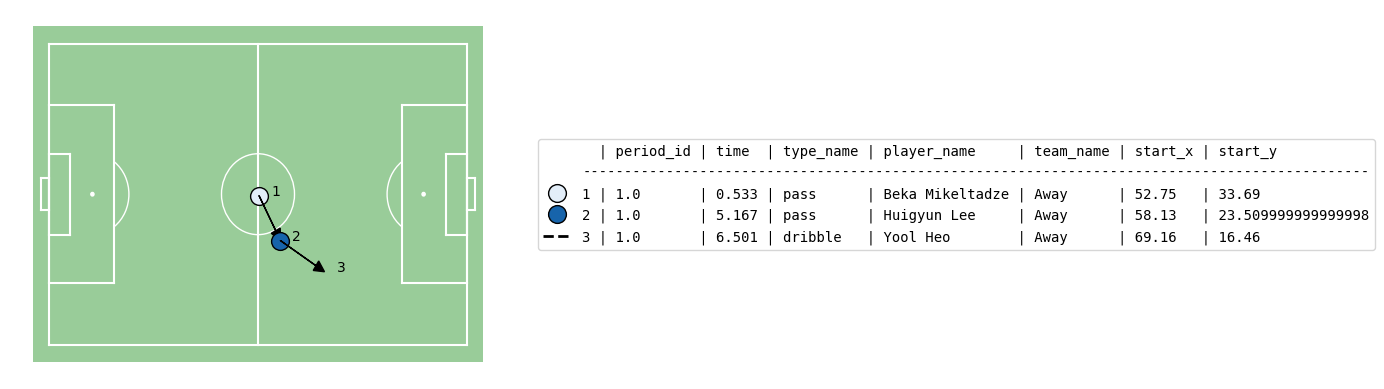

In [24]:
import matplotsoccer as mps

original_event_id = 0
idx = valid_events_filtered[valid_events_filtered["original_event_id"] == original_event_id].index[0]
e = valid_events_filtered[idx:idx+1].copy()
l = min(1, len(e))

for j in range(0, l):
    row = list(e[j:j+1].itertuples())[0]
    i = row.Index
    a = valid_events_filtered.loc[i: i+2].copy()

    for col in ["start_x", "start_y"]:
        a[col] = a[col].apply(lambda x : round(x, 2))

    a["start_x"] += PITCH_X_MAX
    a["start_y"] += PITCH_Y_MAX
    a["time"] = a["time_seconds"].apply(lambda t: f"{int(t // 60)}m{int(t % 60)}s")

   
    a["player_name"] = a["player_id"].apply(lambda x: team_sheets.loc[team_sheets["pID"] == int(x), "player"].values[0])
    a["team_name"] = a["team_id"].apply(lambda x: team_sheets.loc[team_sheets["tID"] == int(x), "team"].values[0])
    
    cols = ["period_id", "time_seconds", "type_name", "player_name",  "team_name", "start_x", "start_y"]
    labeltitle = ["period_id", "time", "type_name", "player_name", "team_name", "start_x", "start_y"]

    mps.actions(a[["start_x", "start_y"]],
                a.type_name,
                team=a.team_name,
                label=a[cols],
                color="green",
                labeltitle = labeltitle,
                zoom=False,
                show=False,
                show_legend= True)

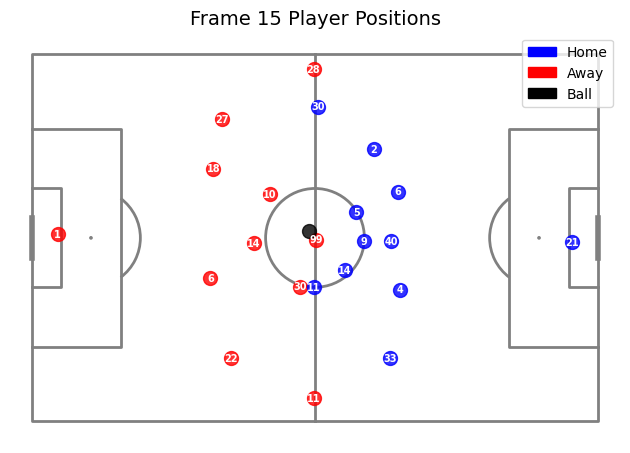

In [25]:
# Visualization

from visualization import plot_single_frame_positions, plot_window_frame_positions

period_id = e.period_id.values[0]
time = e.time_seconds.values[0]
frame_id = time*fps if period_id == 1 else (time + 45*60)*fps

closest_idx = (tracking_df['frame_id'] - frame_id).abs().idxmin()
frame = tracking_df.loc[closest_idx]
plot_single_frame_positions(tracking_df, period_id=period_id, frame_idx=frame.frame_id, home_team_info=teams_dict['Home'], away_team_info=teams_dict['Away'])